# IMPORT

In this notebook I did not normalized images before evolving, just when predicting

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
np.random.seed(0)

# GLOBAL VARS

In [0]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.01
CIFAR_IMG= 32

# THE DATA

In [4]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000
y_train shape: (50000, 10)
input shape:  (32, 32, 1)


# READ PICKLE FILES

In [0]:
with open('subset_cifar', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [6]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (914, 32, 32, 1)
Adversarial shape (133, 32, 32, 1)
Original labels shape (914, 1)
Adversarial labels shape (133, 1)


# LOAD THE MODEL

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.

In [7]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = (CIFAR_IMG,CIFAR_IMG,1)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

model = load_model("CNN_CIFAR10_net3.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

# GENETIC ALGORITHM FUNCTIONS

In [0]:

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(CIFAR_IMG,CIFAR_IMG), target.reshape(CIFAR_IMG,CIFAR_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.2, l2=0.8, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(CIFAR_IMG,CIFAR_IMG),target_image.reshape(CIFAR_IMG,CIFAR_IMG)) +l2*(diff)
  


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, 10)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, CIFAR_IMG*CIFAR_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,CIFAR_IMG*CIFAR_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3), ground_truth.reshape(CIFAR_IMG,CIFAR_IMG), target)
    index_max = np.argmax(scores)
    winner = individuals[index_max]
    return winner


def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (32,32)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG))
  predictions= model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return ind
  return []

def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, CIFAR_IMG*CIFAR_IMG)



Functions from the past, just didn't want to erase them yet

In [0]:
'''
def check_adverserial(pop, model, fitness, target,ground_truth):
    #print(f"this is adversarial function")
    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))
    #print(f"These are predictions made here {preds}")
    for ind, pr in zip(pop,preds): 
      #print(f"prediction for an individual {pr}")
      preds=np.argmax(pr)
      #print(f"getting the index of highest value in predictions {preds}")
      #setting the value to 0
      pr[0]=0
      #print(f"this is our target {target}")
      #print(f"this is out ground_truth {ground_truth.shape}")
      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))
      #print(f"these are the fitness values {fitness}")
      next_highest = np.argmax(pr)
      #print(f"getting the next highest value {next_highest}")
      if next_highest != target and fitness > 0.98:
          return ind, True
      return None, False

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels


Cyrils model

def save_trained_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_trained_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

'''

'\ndef check_adverserial(pop, model, fitness, target,ground_truth):\n    #print(f"this is adversarial function")\n    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))\n    #print(f"These are predictions made here {preds}")\n    for ind, pr in zip(pop,preds): \n      #print(f"prediction for an individual {pr}")\n      preds=np.argmax(pr)\n      #print(f"getting the index of highest value in predictions {preds}")\n      #setting the value to 0\n      pr[0]=0\n      #print(f"this is our target {target}")\n      #print(f"this is out ground_truth {ground_truth.shape}")\n      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))\n      #print(f"these are the fitness values {fitness}")\n      next_highest = np.argmax(pr)\n      #print(f"getting the next highest value {next_highest}")\n      if next_highest != target and fitness > 0.98:\n          return ind, True\n      return None, False\n\ndef init_pop(n, num, data, labels):\n    indices = np.where(labels==num)[0]\n 

In [0]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((CIFAR_IMG,CIFAR_IMG)), parent_2.reshape((CIFAR_IMG,CIFAR_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,CIFAR_IMG-1), np.random.randint(0,CIFAR_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(CIFAR_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  


In [0]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best, np.max(fitness)

In [0]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# THE MAIN LOOP

In [0]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until


Initial fitness: 
 [-0.6010976456294307, -0.6022689701523863, -0.602735085941775, -0.600263577518728, -0.6004837724653709, -0.6001231147149579, -0.6004651497793057, -0.6005222574354647, -0.5998941929190198, -0.6034711283498593, -0.6032364779574653, -0.6017120308282579, -0.6027275385881912, -0.6013435297556654, -0.6007687433088569, -0.6007116198844941, -0.6045636483108575, -0.6013854053890274, -0.6003963202277068, -0.602256690671736, -0.6008555136517845, -0.6000661861240545, -0.6002978818096093, -0.600411770646208, -0.602347152632159, -0.6010247078277335, -0.6003311551125605, -0.6024765107085656, -0.6014261367251998, -0.6004568278739513, -0.6002165397766208, -0.6007035253772012, -0.6019765282742845, -0.6018680460156803, -0.6010888438668501, -0.601701768908935, -0.5998234114610749, -0.600542318833699, -0.6013584281022999, -0.6001534594812556, -0.6018259178867369, -0.6006751201175372, -0.6003416806244822, -0.6008784457132075, -0.6008489912861967, -0.6031788222475647, -0.6007272496199317, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Generation 0
Max fitness value -0.5998234114610749


/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


Generation 10
Max fitness value -0.2092300900118719
Generation 20
Max fitness value 0.9690052197033905
Generation 30
Max fitness value 0.9714973333452399
Generation 40
Max fitness value 0.9720817110292501
Generation 50
Max fitness value 0.9727539288863118
Generation 60
Max fitness value 0.9727539288863118
Generation 70
Max fitness value 0.9730438725139803
Generation 80
Max fitness value 0.9730438725139803
Generation 90
Max fitness value 0.9730438725139803
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


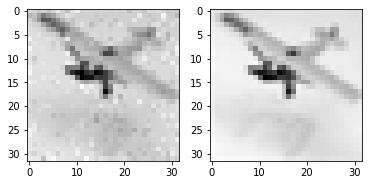

True label: 0
predicted label: 2
Time:  231.70782327651978  seconds
Initial fitness: 
 [-0.48622379010637495, -0.5439337374844601, -0.42773517246128434, -0.5302037573714499, -0.5079860545827883, -0.5008313774115405, -0.4800257889835421, -0.49472101859386597, -0.44224987998031484, -0.5124167960747891, -0.5437820776264932, -0.4442677775951278, -0.49101346847251737, -0.5106837714997077, -0.49620921398386486, -0.523387280797339, -0.562502000331222, -0.4879150719728623, -0.4750806979608897, -0.5056282208683844, -0.5213454523445296, -0.4792421179296522, -0.507027451240475, -0.5002687300482511, -0.48790276693540024, -0.521736159059263, -0.5135958828122484, -0.4455860830392424, -0.500595549088564, -0.5504735545977997, -0.45787015599565106, -0.5378466423098346, -0.4590451047392202, -0.4820391633104478, -0.4693870184358587, -0.4622230330415975, -0.5105102920034233, -0.5146691764845727, -0.4398960281979063, -0.4654981700160424, -0.4339285312503377, -0.5370728951716593, -0.527158486613633, -0.4708

In [0]:
# for each image and label in adversarial
n=50
import time
# these are the examples that are found as adversarialwe will save these at the end in a file
evolved_examples= []
# fitness of the adversarials
fitness_of_evolved=[]
# time necessary to evolve the adversarial
times=[]
# the distance between the original image and the adversarial
ssim_values=[]
# number of round necessary to produce adversarial 
number_of_rounds=[]
# this will serve to see if the fitness changes or not 
best_fitness = 0


numb_of_found_after30=0
numb_of_adv_found=0

#dictionary to keep the best individual to check if the fitness is improving or not 


predicted_class= []
for img,label in zip(adversarial,adversarial_y):
  winner_of_gen = {"image":[],"label": None, "fitness": None}
  #temporary variable to check generations:
  fitness_no_change = 0
  start = time.time()
  label=label[0]
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label)
  print(f"Initial fitness: \n {fitness}")
  #retun the best one from the population
  best,fit_max = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  #define max generation
  max_gen=0

  while (len(check_adv)==0 or max_gen<10000):
      new_pop=[]
      for i in range(50):
        parent1= tournament(population, model, img, label) 
        parent2 = tournament(population, model, img, label)
        if 0.8 > np.random.uniform(0.0, 1.0):
          child1, child2 = quadrant_crossover(parent1, parent2) # crossover
          new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        else:
          new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))

      # to reshape into an array 
      population= np.array(new_pop)
      #check fitness of the generation
      fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
      #find the highest fitness
      best,fit_max1 = return_best_individual(population,fitness)
      # check adversarial - check if pred != target, distance < 0.001 or fitness didn't improve 0.001 after 30 generations(this is in else condition)
      check_adv = check_adv_termination(best,label,img,model)

      #check if the first termination true 
      if(len(check_adv) != 0):
        print("Adversarial example image: \n")
        evolved_examples.append(check_adv) #add evolved example
        ssim_values.append(1-compare_ssim(check_adv.rehspe(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG))) #add the distance
        end=time.time()
        times.append(end-start) #add the time 
        fitness_of_evolved.append(calculate_fitness(model,check_adv,img,label)) #add the fitness value of adversarial
        number_of_rounds.append(max_gen)
        pred_l=np.argmax(model.predict(check_adv.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}") 
        print("Time: ",end-start ," seconds")
        numb_of_adv_found+=1
        break
      #check the second termination 
      else:
          #check if fitness increases, if not , add +1 to temporary var
        if fit_max1>fit_max:
          fit_max=fit_max1
          winner_of_gen.update(image= best)
          winner_of_gen.update(label= label)
          winner_of_gen.update(fitness= fit_max1)
          fitness_no_change=0
        else:
          fitness_no_change+=1
      
      #print after every 10 generations to see the progress
      if (max_gen % 10 == 0):
        print(f"Generation {max_gen}")
        print(f"Max fitness value {fit_max}")
      max_gen+=1

      # if fitness did not improve for 30 generations, save the image that was best , saved it in a dicitonary
      if fitness_no_change==30:
        print("FITNESS DID NOT IMPROVE FOR 30 GENERATIONS")
        print("Best adversarial image we could find: \n")
        evolved_examples.append(winner_of_gen["image"])
        ssim_values.append(1-compare_ssim(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG)))
        number_of_rounds.append(max_gen)
        end=time.time()
        times.append(end-start)
        fitness_of_evolved.append(winner_of_gen["fitness"])
        pred_l=np.argmax(model.predict(np.array(winner_of_gen["image"]).reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}")
        print("Time: ",end-start ," seconds")
        numb_of_found_after30 +=1
        break




# Save files


In [0]:
import pickle
file_ = open('GA_adv_cifar_QUADRANT_multicrossover', 'wb')
pickle.dump(evolved_examples, file_)
pickle.dump(times, file_)
pickle.dump(ssim_values, file_)
pickle.dump(fitness_of_evolved , file_)
pickle.dump(predicted_class, file_)
pickle.dump(number_of_rounds, file_)
file_.close()

print(f"Max time: {np.max(times)}")
print(f"Min time: {np.min(times)}")
print(f"Mean time: {np.mean(times)}")
print(f"Std time: {np.std(times)}\n")

print(f"Max fitness evolved: {np.max(fitness_of_evolved)}")
print(f"Min fitness evolved:: {np.min(fitness_of_evolved)}")
print(f"Mean fitness evolved: {np.mean(fitness_of_evolved)}")
print(f"Std fitness evolved:: {np.std(fitness_of_evolved)}\n")

print(f"Max ssim: {np.max(ssim_values)}")
print(f"Min ssim: {np.min(ssim_values)}")
print(f"Mean ssim: {np.mean(ssim_values)}")
print(f"Std ssim: {np.std(ssim_values)}\n")

print(f"Max ssim: {np.max(number_of_rounds)}")
print(f"Min ssim: {np.min(number_of_rounds)}")
print(f"Mean ssim: {np.mean(number_of_rounds)}")
print(f"Std ssim: {np.std(number_of_rounds)}\n")




print(f"Percentage of adversarial founds sucessfully : {numb_of_adv_found/len(adversarial_y)} %")
print(f"Percentage of adversarial founds after fitness not improving for 30 generations: {numb_of_found_after30/len(adversarial_y)} %")


Open adversarial

In [0]:
with open('GA_adv_cifar_QUADRANT_multicrossover', 'rb') as f:
    evolved_examples = pickle.load(f)
    times= pickle.load(f)
    ssim_values = pickle.load(f)
    fitness_of_evolved = pickle.load(f)
    predicted_class = pickle.load(f)
    number_of_rounds = pickle.load(f)

# Examples of what functions do

In [0]:
population = init_pop_from_sample(50,adversarial[15],adversarial_y[15][0])
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),adversarial_y[15][0])
print(fitness)

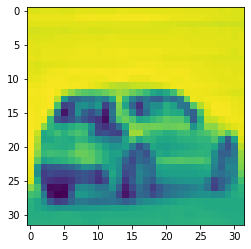

Class for this 1
[[2.2063480e-10 1.0000000e+00 6.6041472e-14 3.5760719e-12 3.9276270e-13
  1.1313486e-13 8.8119643e-13 6.8588521e-13 1.9681285e-13 3.7839783e-08]]


In [0]:
plt.imshow(population[0].reshape(CIFAR_IMG,CIFAR_IMG))
plt.show()
print(f"Class for this {adversarial_y[15][0]}")
print(model.predict(population[0].reshape(1,CIFAR_IMG,CIFAR_IMG,1) /255.0))

In [0]:
parent1 = tournament(population, model, adversarial[15], adversarial_y[15]) 
parent2 = tournament(population, model, adversarial[15], adversarial_y[15])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


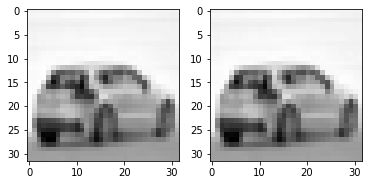

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(parent2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")

In [0]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[15]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


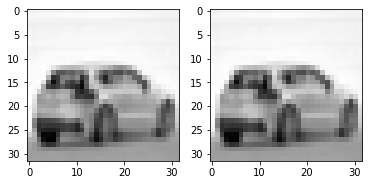

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(child2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")


In [0]:
print(f"diff between children {np.unique(child1-child2)}")
print(f"diff between parents {np.unique(parent1-parent2)}")
print(f"diff between p1 and c1 {np.unique(parent1-child1)}")
print(f"diff between p1 and c2 {np.unique(parent1-child2)}")
print(f"diff between p2 and c1 {np.unique(parent2-child1)}")
print(f"diff between p2 and c2 {np.unique(parent2-child2)}")

In [0]:
bb = choose_better_child(child1, child2,adversarial[15],adversarial_y[15][0],model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


In [0]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
print(fitness)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


[-0.26002962878595726, -0.25999958545736684, -0.26007314251448344, -0.26004007622401076, -0.26003266487525345, -0.26011373574731095, -0.2599816460817825, -0.25998496480763594, -0.2600353571926644, -0.2600021864303609, -0.260040721413234, -0.2600228430135187, -0.26003768485830203, -0.26002701209750284, -0.26006302743228543, -0.2599796432991168, -0.2600043346069123, -0.26003024147792836, -0.2600466627237271, -0.26003812318804226, -0.2600652442884724, -0.2600447098702882, -0.2600085762943468, -0.26001327339828323, -0.2599806557454484, -0.26007237070197037, -0.25996000471207786, -0.2600457997287944, -0.2600101441535663, -0.26005323947618036, -0.2600554130353725, -0.2600860828123626, -0.26003997918862914, -0.26004537198733424, -0.2600515291553301, -0.2600503663988854, -0.26001231736237695, -0.2600170667581806, -0.2600851316879575, -0.2599960477747653, -0.260017809873727, -0.2600171997460062, -0.2600455137861651, -0.26001145913341955, -0.2600466317811507, -0.2600557191632309, -0.260061281083